<a href="https://colab.research.google.com/github/dlsyscourse/lecture5/blob/main/5_automatic_differentiation_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Differentiation Framework Implementation

In this lecture, we will walk through the design elements of an automatic differentiation framework.

We won't implement the automatic differentiation(that is part of your homework), but we will walk through all the scaffolds that build up our overall framework.




We can then run the following command to make the path to the package available in colab's environment as well as the PYTHONPATH.

## Needle codebase walkthrough

Now click the files panel on the left side. You should be able to see the following files:

- `needle/python/needle`
    - `__init__.py`
    - `auograd.py`
    - `backend_numpy.py`
    - `ops/`

Tianqi Chen has implemented a framework called needle (https://dlsyscourse.org/) for deep learning framework tutorial. Needle stands for **ne**cessary **e**lements of **d**eep **le**arning.
You can also viewed it as a sewing needle that threads through clothes
to form (neural)net patterns, and the create traces for automatic differentiation.




### Tensor creation and manipulation




In [1]:
import needle as ndl

We can call perform array operations on needle Tensors. The following code creates a new Tensor y by adding a constant scalar to x.

In [ ]:
x = ndl.Tensor([1,2,3], dtype="float32")
x

We provide common operator overloadingss so you can also directly write + and the call redirects to ndl.add_scalar.

We can call `y.numpy()` to explicitly convert a needle Tensor to a numpy ndarray. Note for numpy backend, needle tensor is backed by an numpy.ndarray so there isn't much a difference here. However, we will implement other non-numpy backends that are backed by different kind of devices.

In [ ]:
y = x + 1
y.numpy()

In [ ]:
y = ndl.add_scalar(x, 1)
y

### Key Data Structures

Needle contains the following key data structures:

- Value: represent a value "node" in a computational graph
    - Tensor is a subclass of Value.
    - We might introduce other kinds of Value in the future (e.g. tuple of tensors)
- Op: represent the kind of computation we perform at each node.



In [ ]:
isinstance(y, ndl.autograd.Value)

In [ ]:
y.op

In [ ]:
y.op.__dict__

## Computational Graph

When running array computations, needle not only executes the arithmetic operations, but also creates a computational graph along the way.

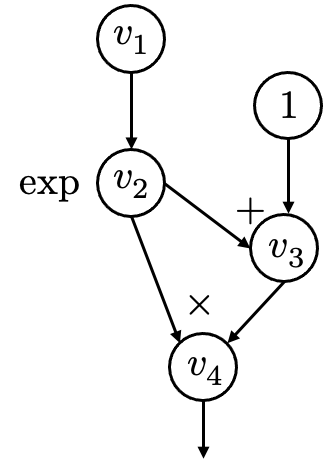

In [ ]:
v1 = ndl.Tensor([0], dtype="float32")
v2 = ndl.exp(v1)
v3 = v2 + 1
v4 = v2 * v3

v4.inputs[0].inputs[0] is v1

In [ ]:
def print_node(node):
    print(f"id={id(node)}")
    print(f"op={node.op}")
    print(f"{[id(x) for x in node.inputs]}")

print("v4")
print_node(v4)
print("v3")
print_node(v3)


In [ ]:
v4.inputs[1] is v3

 NOTE: we need to open up the ops and add implementation of exp in order for the following code to run



In [11]:
v1 = ndl.Tensor([0], dtype="float32")
v2 = ndl.exp(v1)
v3 = v2 + 1
v4 = v2 * v3

`v4.inputs` contains the input values to the operation


In [ ]:
v4.inputs

We further confirm that `v4.inputs == [v2, v3]`

In [ ]:
v4.inputs[0] is v2 and v4.inputs[1] is v3

Besides the inputs field. v4 also contains an `op` field that record the operaiton performed. In this case the operation is EWiseMulOp.

In [ ]:
v4.op

v3 is an add scalar node that represents a constant scalar add to an input.




In [ ]:
v3.op

v3 only have one input(v2)


In [ ]:
v3.inputs

v3's op class also contains a field that stores the scalar constant

In [ ]:
v3.op.__dict__

## Executing the Computation

Now let us take a deeper look at what happens when we run an array operation.
Specifically, what happens when we run needle computations.

In [18]:
x1 = ndl.Tensor([3], dtype="float32")
x2 = ndl.Tensor([4], dtype="float32")

In [19]:
y = x1 + x2

In [ ]:
y.shape
y.cached_data

In [21]:
x = ndl.Tensor([2], dtype="float32")

In [22]:
sum_loss = ndl.Tensor([0], dtype="float32")

In [23]:
for i in range(100):
    sum_loss = sum_loss + x * x

In [ ]:
sum_loss.inputs[0].inputs

In [ ]:
sum_loss.inputs

In [26]:
x = ndl.Tensor([3], dtype="float32")

In [27]:
sum_loss = ndl.Tensor([0], dtype="float32")

In [28]:
for i in range(100):
    sum_loss = (sum_loss + x * x).detach()

In [ ]:
sum_loss.inputs

In [ ]:
y = x + 1
y_detached = y.detach()
y_detached.op is None

In [ ]:
import needle as ndl
x1 = ndl.Tensor([3], dtype="float32")
x2 = ndl.Tensor([4], dtype="float32")
x3 = x1 * 2
x3.numpy()

Open up the code browser, check the following functions along the calling path.
- `autograd.TensorOp.__call__` calls into
- `autograd.Tensor.make_from_op` calls into
- `autograd.Tensor.realize_cached_data` calls into
- `x3.op.compute`

A few key points to note here:
- `make_from_op` constructs the computational graph node.
- The actual computation won't happen until `realize_cached_data` is called.


In [ ]:
x3.op.compute.__code__

The following code above us to find the location of the compute implementation.
- Here `array_api` simply points to numpy
- In the later lectures, we will replace `array_api` with our own implementation of NDArray.


Each of the Value node stores a `cached_data` field that corresponds to the computed data. Because we are using numpy as our array api, the cached_data is a numpy.ndarray.

In [ ]:
type(x3.cached_data)

In [ ]:
x3.cached_data

### Lazy Evaluation

We also support a lazy evaluation mode. In this case, we do not compute cached_data right away. But cached_data will be computed once we need the actual result (when we call x3.data, x3.numpy() or othercases).


In [35]:
ndl.autograd.LAZY_MODE = True
x1 = ndl.Tensor([3], dtype="float32")
x2 = ndl.Tensor([4], dtype="float32")
x3 = x1 * x2

We can see that x3's cached_data field is not yet readily available. But as soon as we call x3.numpy(), a call to `x3.realize_cached_data()` will get triggered to compute the actual value.

In [ ]:
x3.cached_data is None

In [ ]:
x3.numpy()

In [ ]:
x.cached_data

By default we use eager evaluation mode that always directly realizes the computation, but lazy evaluation can also be helpful for some advanced optimizations later.

## Reverse mode AD

Now we are ready to talk about reverse mode AD. As a recap from last lecture, we will need to traverse the computational graph in reverse topological order, and construct the new adjoint nodes(Tensors).

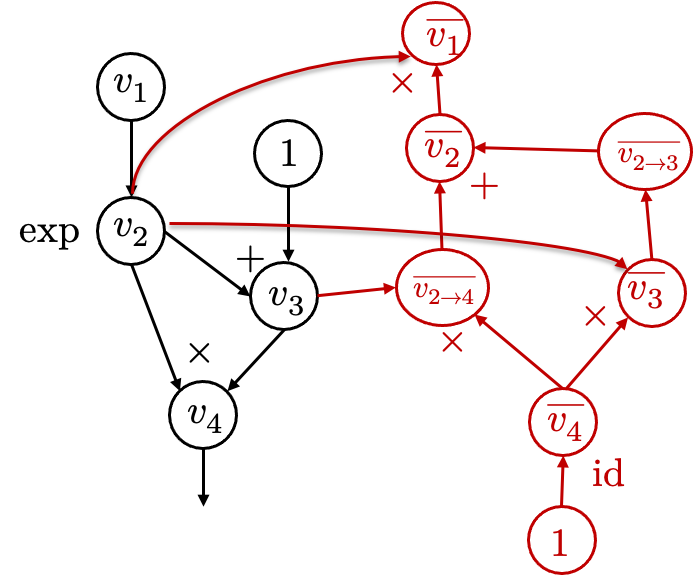

You will need to complete the implementations in autograd.py to enable the backward function. That computes the gradient and store them in the grad field of each input Tensor.

In [39]:
v2adj, v3adj = v4.op.gradient_as_tuple(
    ndl.Tensor([1], dtype="float32"),
    v4,
)

In [40]:
v1 = ndl.Tensor([0], dtype="float32")
v2 = ndl.exp(v1)
v3 = v2 + 1
v4 = v2 * v3
v4.backward()

In [ ]:
v2adj.inputs

Each op have a gradient function, that defines how to propagate adjoint back into its inputs(as partial adjoints). We can look up the gradient implementation of v4.op as follows(impl of gradient for multiplication)


In [ ]:
v4.op.gradient.__code__

In [ ]:
v4.op

The gradient function defines a single step to propagate the output adjoint to partial adjoints of its inputs.

In [ ]:
x = ndl.Tensor([1.0, 2.0, 3.0], requires_grad=True)
y = ndl.Tensor([4.0, 5.0, 6.0], requires_grad=True)
z = x + y
print("z:", z.data)

# 计算梯度
z.backward()
print("x.grad:", x.grad)
print("y.grad:", y.grad)

In [ ]:
# 导入优化器
from needle.optim import SGD

# 定义参数列表
params = [x, y]

optimizer = SGD(params, lr=0.01)

for i in range(10):
    z = x + y
    print(f"Step {i+1}: z = {z.data}")

    # 反向传播
    z.backward()

    # 更新参数，重置梯度
    optimizer.step()
    optimizer.zero_grad()
print("更新后的 x:", x.data)
print("更新后的 y:", y.data)


In [5]:
import numpy as np
import needle as ndl
from needle import nn
from needle.optim import SGD
from needle.nn import SoftmaxLoss

# 定义一个简单的线性模型
class LinearModel:
    def __init__(self, in_features, out_features):
        # 初始化权重和偏置
        self.weights = ndl.Tensor(np.random.randn(in_features, out_features), requires_grad=True)
        self.bias = ndl.Tensor(np.zeros(out_features), requires_grad=True)

    def __call__(self, x):
        # 前向传播：线性变换
        return x @ self.weights + self.bias

# 随机生成数据
num_samples = 100
input_dim = 28 * 28  # 输入维度
output_dim = 5       # 输出类别数量
X = np.random.randn(num_samples, input_dim).astype(np.float32)
y = np.random.randint(0, output_dim, size=(num_samples,)).astype(np.int64)

model = LinearModel(input_dim, output_dim)
loss_fn = SoftmaxLoss()

# 数据标准化
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

optimizer = SGD([model.weights, model.bias], lr=0.001)

# 训练过程
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx in range(num_samples):
        logits = model(ndl.Tensor(X[batch_idx].reshape(1, -1)))
        loss = loss_fn(logits, ndl.Tensor(y[batch_idx].reshape(1,)))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.data}")



AttributeError: 'MLP' object has no attribute 'parameters'

大家可以试试用优化器以及经典的数据集自己训练一下，看看和pytorch等框架有何异同。

## Additional Remarks

While needle is designed as a minimalist framework, it contains a comprehensive the bells and whistles of standard deep learning frameworks.

- Read and think about the relation between Tensor, array_api and underlying NDArray.
- Think about how gradient are implemented.